# Библиотеки

In [1]:
import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    !git clone -qq https://github.com/kbayazitov/Distillation.git /tmp/repo
    !python3 -m pip install -qq /tmp/repo/src/ && rm -rf /tmp/repo

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 15.7 MB 5.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import torch
from torchvision import datasets, transforms

In [3]:
from pylab import rcParams

rcParams['figure.figsize'] = (20.0, 10.0)
rcParams['legend.fontsize'] = 20
rcParams['axes.titlesize']=20
rcParams['axes.labelsize']=20
rcParams['font.size'] = 20
rcParams['lines.linewidth'] = 3
rcParams['axes.formatter.use_locale'] = True

In [4]:
from mylib.train import (label_to_digit, Perceptron, TeacherModel, train_teacher, distillation_train,
                         train_teacher_reg, distillation_train_reg, generate_regression,
                         trainer, VAE, draw_samples_grid_vae, fmnist_to_mnist, fmnist_to_fmnist,
                         GeneratedMNIST, add_noise, dilation, makeplots)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Данные

In [7]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=transforms.ToTensor())
MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=transforms.ToTensor())

In [7]:
FMNIST_train = datasets.FashionMNIST('./fmnist', train=True, download=True, 
                             transform=transforms.ToTensor())

FMNIST_test = datasets.FashionMNIST('./fmnist', train=False, download=True,
                            transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



In [8]:
fmnist_big, fmnist_small = torch.utils.data.random_split(FMNIST_train, [59000, 1000], generator=torch.Generator().manual_seed(SEED))

In [10]:
mnist_big, mnist_small = torch.utils.data.random_split(MNIST_train, [59000, 1000], generator=torch.Generator().manual_seed(SEED))

In [11]:
FashionDigit = torch.utils.data.TensorDataset(FMNIST_train.data/255,
                                              label_to_digit(MNIST_train, FMNIST_train.targets))

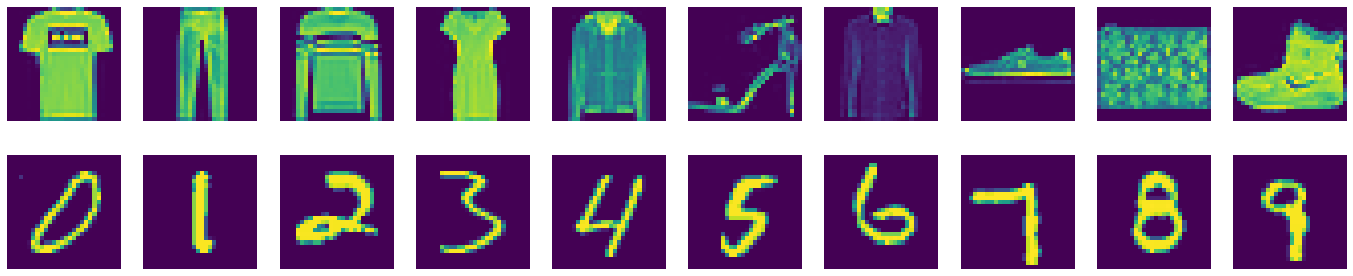

In [12]:
indices = [1,16,5,20,28,8,33,14,23,0]

fmnist_images = []
for i in indices:
    fmnist_images.append(FashionDigit[i][0])

mnist_images = []
for i in indices:
    mnist_images.append(FashionDigit[i][1])   

fig, gs = plt.figure(figsize=(24,5)), gridspec.GridSpec(2, 10)

ax = []

for i in range(10):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(fmnist_images[i].view([28,28])))
    ax[i].axis('off')

for i in range(10):
    ax.append(fig.add_subplot(gs[i+10]))
    ax[i+10].imshow(np.array(mnist_images[i].cpu()))
    ax[i+10].axis('off')

plt.show()

# Экспримент с задачей регрессии

## Выборка из нормального распределения

In [22]:
reg_dataset = generate_regression()
Reg_train, Reg_test = torch.utils.data.random_split(reg_dataset, [9000, 1000], generator=torch.Generator().manual_seed(SEED))
Reg_big, Reg_small = torch.utils.data.random_split(Reg_train, [8700, 300], generator=torch.Generator().manual_seed(SEED))

## Дистилляция на всей выборке

In [ ]:
Student = Perceptron(num_layers=1, hidden_dim=32, input_dim=100, output_dim=1)
Student.to(device)
_ = Student.train()
reg_test_losses, _ = distillation_train_reg(Student, Reg_train, Reg_test, SEED=0)

In [ ]:
Teacher = TeacherModel(input_dim=100, output_dim=1)
Teacher.to(device)
_ = Teacher.train()
train_teacher_reg(Teacher, Reg_train, Reg_test, SEED=0)

In [ ]:
Student = Perceptron(num_layers=1, hidden_dim=32, input_dim=100, output_dim=1)
Student.to(device)
_ = Student.train()
reg_test_losses_dist, _ = distillation_train_reg(Student, Reg_train, Reg_test, SEED=0, teacher=Teacher)

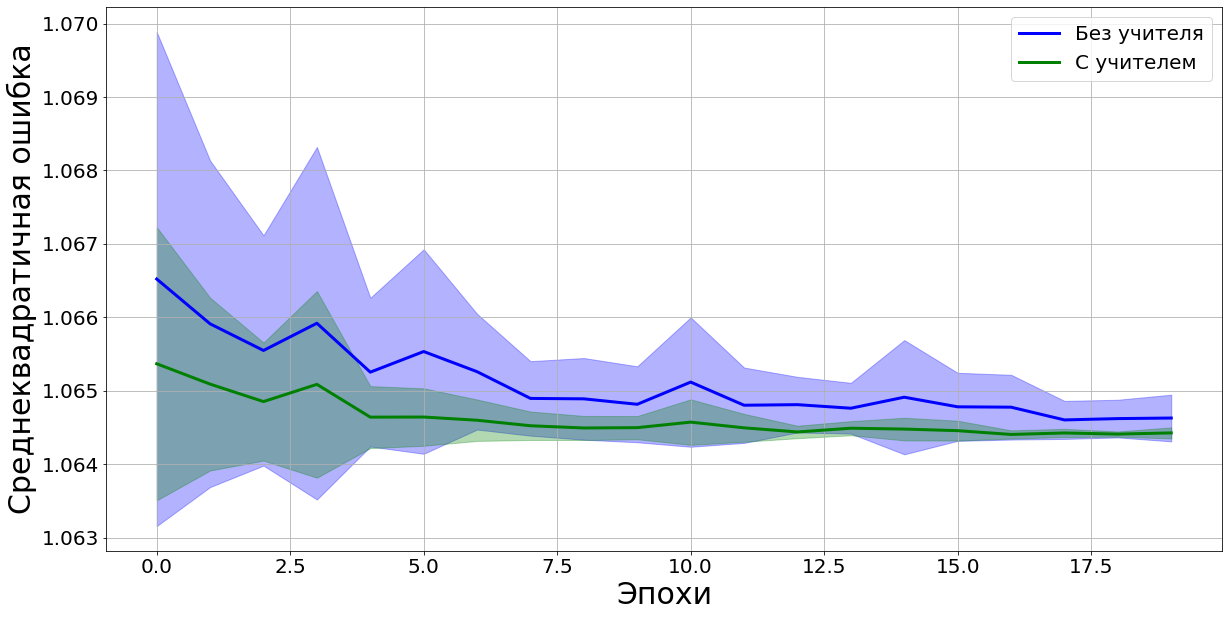

In [44]:
labels = ['Без учителя', 'С учителем']

makeplots(losses=[reg_test_losses, reg_test_losses_dist],
          labels=labels, task='Regression')

In [45]:
print('Loss of student without teacher on all dataset={}+-{}'.format(round(np.array(reg_test_losses).mean(0)[-1], 4),
                                                      round(np.array(reg_test_losses).std(0)[-1],4)))
print('Loss of student with teacher on all dataset={}+-{}'.format(round(np.array(reg_test_losses_dist).mean(0)[-1],4),
                                                   round(np.array(reg_test_losses_dist).std(0)[-1],4)))

Loss of student without teacher on all dataset=1.0646+-0.0003
Loss of student with teacher on all dataset=1.0644+-0.0001


## Дистилляция на малоресурсной части

In [ ]:
Student = Perceptron(num_layers=1, hidden_dim=32, input_dim=100, output_dim=1)
Student.to(device)
_ = Student.train()
reg_test_losses, _ = distillation_train_reg(Student, Reg_small, Reg_test)

In [ ]:
Teacher = TeacherModel(input_dim=100, output_dim=1)
Teacher.to(device)
_ = Teacher.train()
train_teacher_reg(Teacher, Reg_big, Reg_test)

In [ ]:
Student = Perceptron(num_layers=1, hidden_dim=32, input_dim=100, output_dim=1)
Student.to(device)
_ = Student.train()
reg_test_losses_dist, _ = distillation_train_reg(Student, Reg_small, Reg_test, teacher=Teacher)

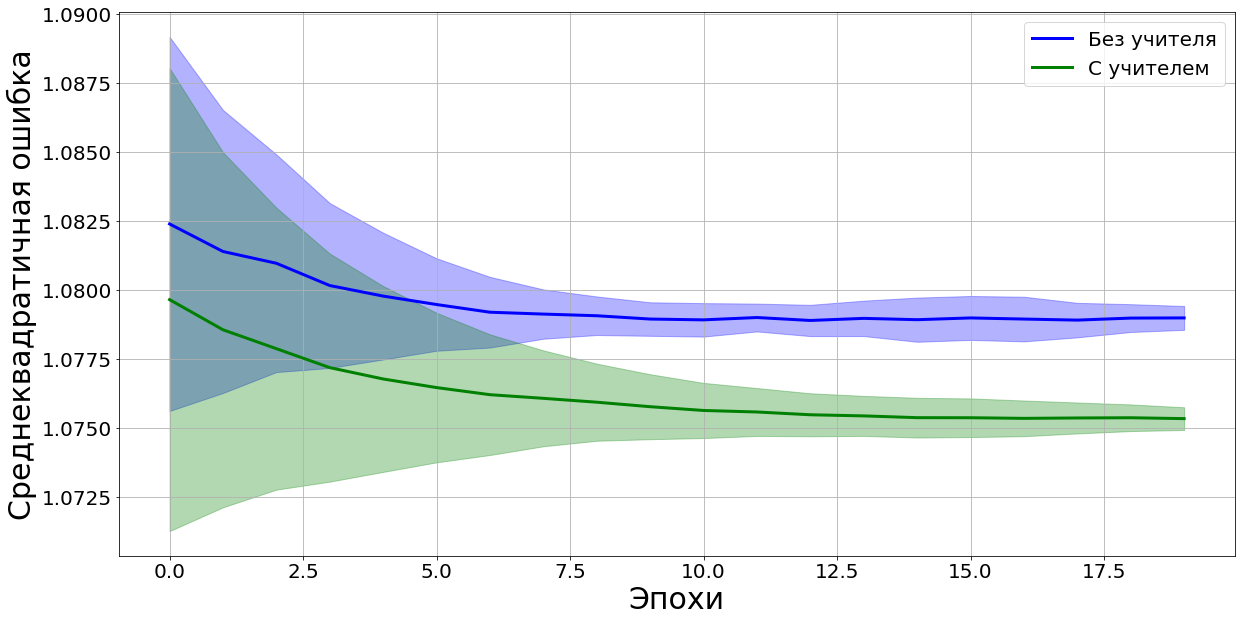

In [57]:
labels = ['Без учителя', 'С учителем']

makeplots(losses=[reg_test_losses, reg_test_losses_dist],
          labels=labels, task='Regression')

In [58]:
print('Loss of student without teacher={}+-{}'.format(round(np.array(reg_test_losses).mean(0)[-1], 4),
                                                      round(np.array(reg_test_losses).std(0)[-1],4)))
print('Loss of student with teacher={}+-{}'.format(round(np.array(reg_test_losses_dist).mean(0)[-1],4),
                                                   round(np.array(reg_test_losses_dist).std(0)[-1],4)))

Loss of student without teacher=1.079+-0.0004
Loss of student with teacher=1.0753+-0.0004


## Дистилляция на выборке с преобразованием $\sin{x}$

In [ ]:
Student = Perceptron(num_layers=1, hidden_dim=32, input_dim=100, output_dim=1).to(device)
Teacher = TeacherModel(input_dim=100, output_dim=1).to(device)

_ = Teacher.train()
train_teacher_reg(Teacher, Reg_big, Reg_test, phi=lambda x: torch.sin(x))

_ = Student.train()
reg_test_losses_sin, _ = distillation_train_reg(Student, Reg_small, Reg_test, teacher=Teacher, phi=lambda x: torch.sin(x))

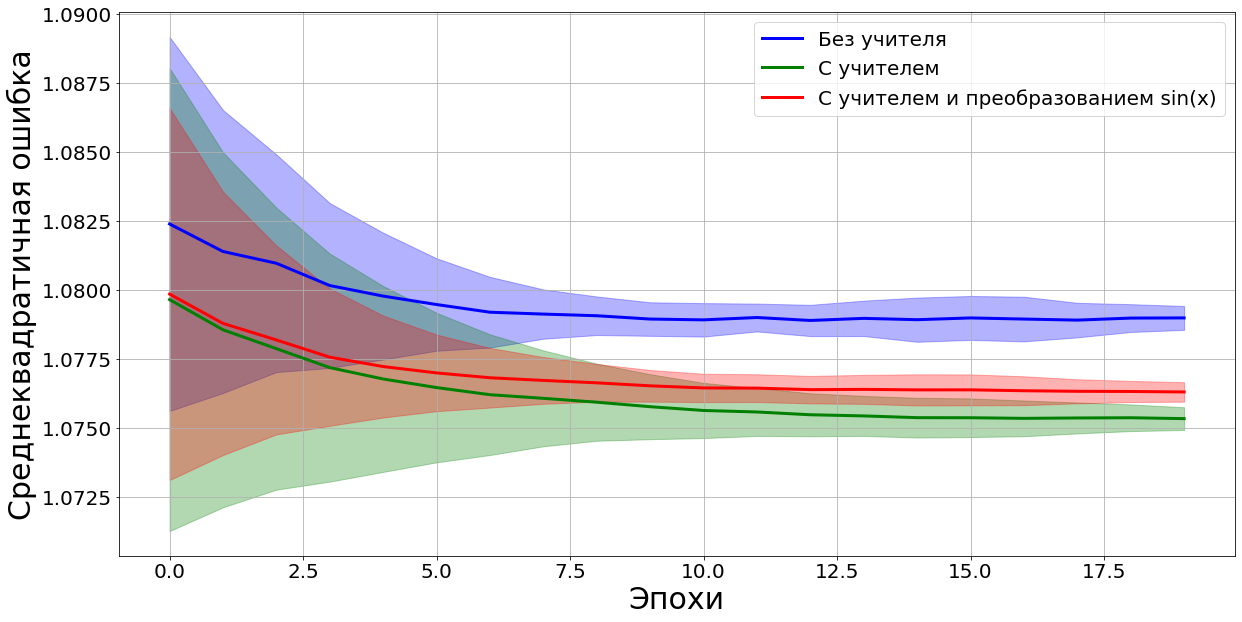

In [60]:
labels = ['Без учителя', 'С учителем', 'С учителем и преобразованием sin(x)']

makeplots(losses=[reg_test_losses, reg_test_losses_dist, reg_test_losses_sin],
          labels=labels, task='Regression')

In [61]:
print('Loss of student with teacher and sin(x)={}+-{}'.format(round(np.array(reg_test_losses_sin).mean(0)[-1], 4),
                                                      round(np.array(reg_test_losses_sin).std(0)[-1],4)))

Loss of student with teacher and sin(x)=1.0763+-0.0004


# Обучение на всей выборке

In [ ]:
Student = Perceptron(num_layers=1)
Student.to(device)
_ = Student.train()
list_of_test_acc, list_of_test_losses, _, _ = distillation_train(Student, FMNIST_train, FMNIST_test, SEED=10)

In [ ]:
Teacher = TeacherModel()
Teacher.to(device)
_ = Teacher.train()
train_teacher(Teacher, FMNIST_train, FMNIST_test, SEED=10)

In [ ]:
Student = Perceptron(num_layers=1)
Student.to(device)
_ = Student.train()
list_of_test_acc_dist, list_of_test_losses_dist, _, _ =\
                        distillation_train(Student, FMNIST_train, FMNIST_test, SEED=10, teacher=Teacher)

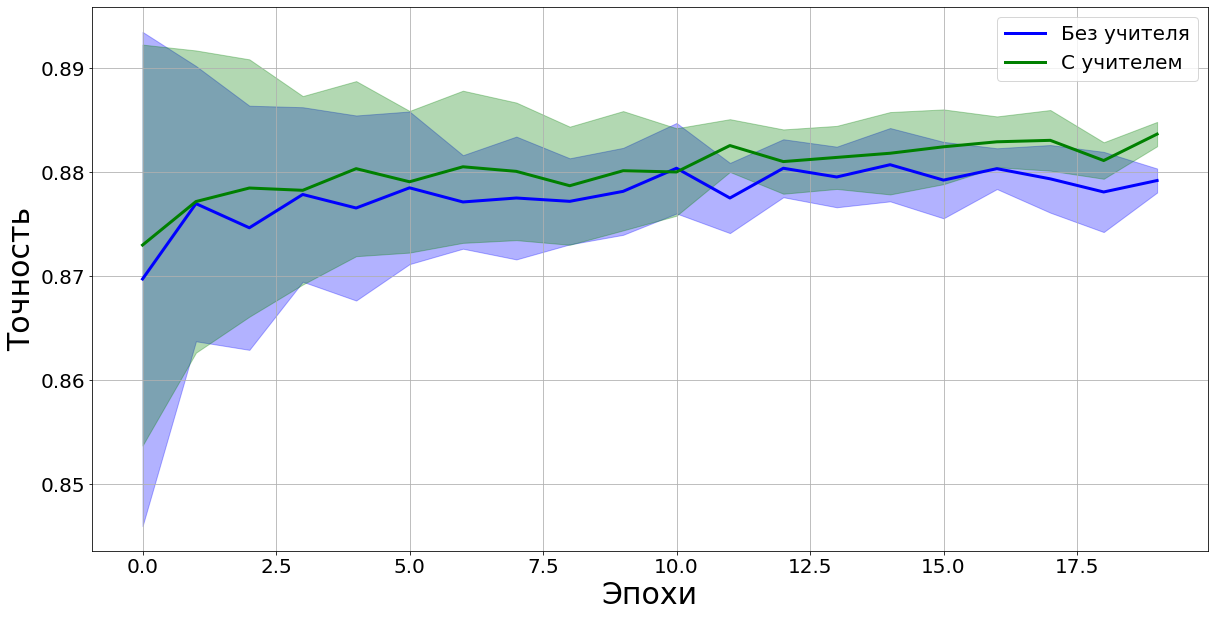

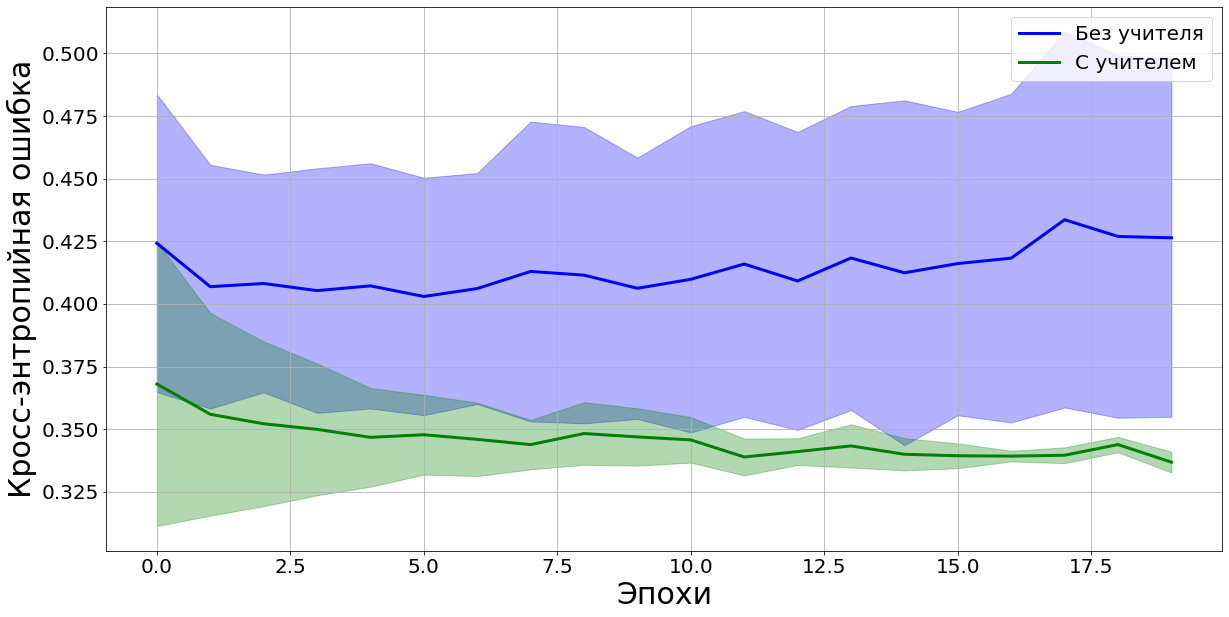

In [37]:
labels = ['Без учителя', 'С учителем']

makeplots(losses=[list_of_test_losses, list_of_test_losses_dist],
          labels=labels,
          accs=[list_of_test_acc, list_of_test_acc_dist])

In [38]:
print('Accuracy of student without teacher on all dataset={}+-{}'.format(round(np.array(list_of_test_acc).mean(0)[-1], 3),
                                                          round(np.array(list_of_test_acc).std(0)[-1],3)))
print('Loss of student without teacher on all dataset={}+-{}'.format(round(np.array(list_of_test_losses).mean(0)[-1], 3),
                                                      round(np.array(list_of_test_losses).std(0)[-1],3)))
print('Accuracy of student with teacher on all dataset={}+-{}'.format(round(np.array(list_of_test_acc_dist).mean(0)[-1],3),
                                                       round(np.array(list_of_test_acc_dist).std(0)[-1],3)))
print('Loss of student with teacher on all dataset={}+-{}'.format(round(np.array(list_of_test_losses_dist).mean(0)[-1],3),
                                                   round(np.array(list_of_test_losses_dist).std(0)[-1],3)))
print('Integral criterion without teacher on all dataset={}+-{}'.format(round(np.trapz(np.array(list_of_test_losses).mean(0), np.arange(0,20)), 3),
                                                                        round(np.trapz(np.array(list_of_test_losses).std(0), np.arange(0,20)), 3)))
print('Integral criterion with teacher on all dataset={}+-{}'.format(round(np.trapz(np.array(list_of_test_losses_dist).mean(0), np.arange(0,20)), 3),
                                                                     round(np.trapz(np.array(list_of_test_losses_dist).std(0), np.arange(0,20)), 3)))

Accuracy of student without teacher on all dataset=0.879+-0.001
Loss of student without teacher on all dataset=0.426+-0.071
Accuracy of student with teacher on all dataset=0.884+-0.001
Loss of student with teacher on all dataset=0.337+-0.004
Integral criterion without teacher on all dataset=7.853+-1.105
Integral criterion with teacher on all dataset=6.561+-0.264


# Обучение ученика и учителя на малоресурсной выборке

In [ ]:
Student = Perceptron(num_layers=1)
Student.to(device)
_ = Student.train()
list_of_test_acc, list_of_test_losses, _, _= distillation_train(Student, fmnist_small, FMNIST_test)

In [ ]:
Teacher = TeacherModel()
Teacher.to(device)
_ = Teacher.train()
train_teacher(Teacher, fmnist_big, FMNIST_test)

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Student.to(device)
_ = Student.train()
list_of_test_acc_dist, list_of_test_losses_dist, _, _ =\
                        distillation_train(Student, fmnist_small, FMNIST_test, teacher=Teacher)

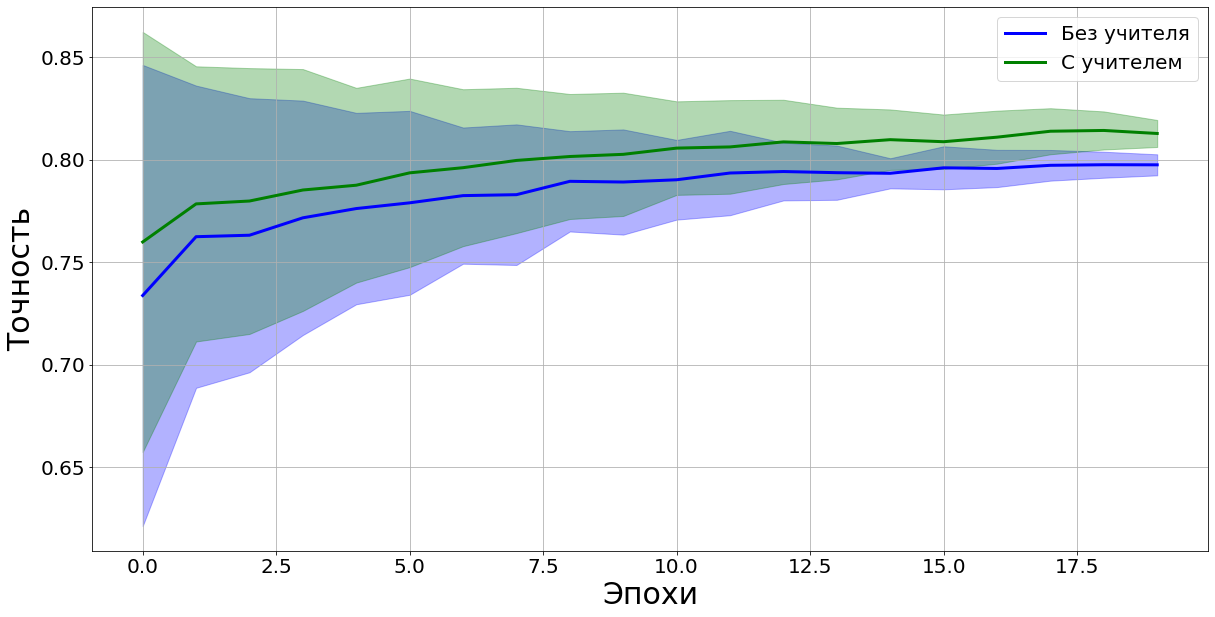

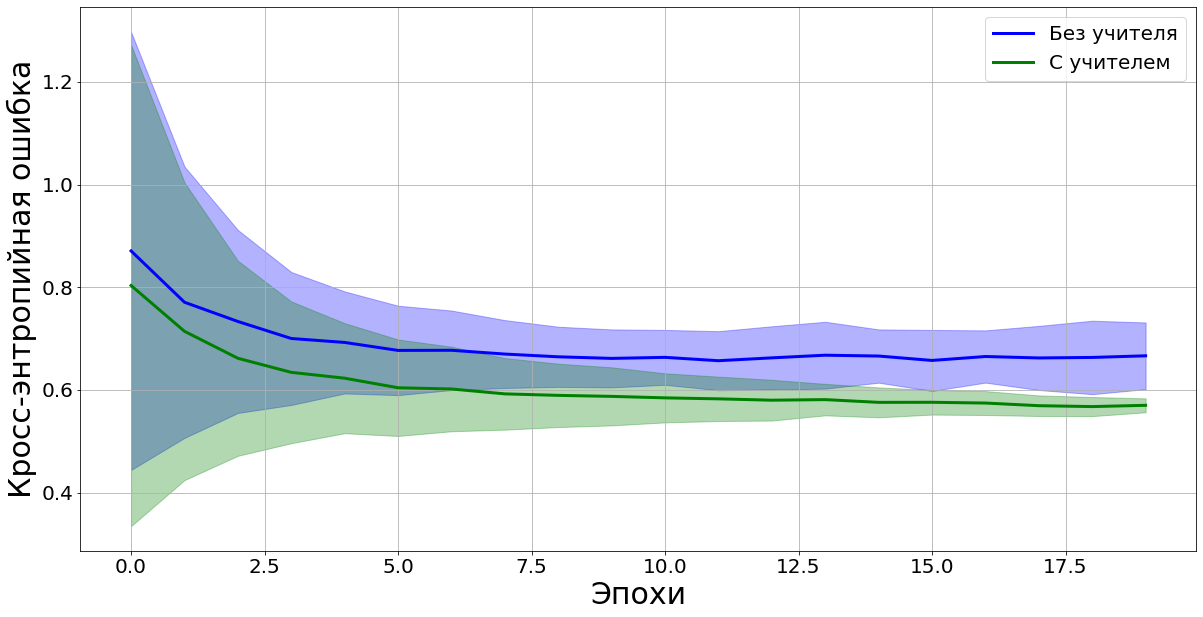

In [16]:
labels = ['Без учителя', 'С учителем']
makeplots(losses=[list_of_test_losses, list_of_test_losses_dist],
          labels=labels,
          accs=[list_of_test_acc, list_of_test_acc_dist])

In [17]:
print('Accuracy of student without teacher={}+-{}'.format(round(np.array(list_of_test_acc).mean(0)[-1], 3),
                                                          round(np.array(list_of_test_acc).std(0)[-1],3)))
print('Loss of student without teacher={}+-{}'.format(round(np.array(list_of_test_losses).mean(0)[-1], 3),
                                                      round(np.array(list_of_test_losses).std(0)[-1],3)))
print('Accuracy of student with teacher={}+-{}'.format(round(np.array(list_of_test_acc_dist).mean(0)[-1],3),
                                                       round(np.array(list_of_test_acc_dist).std(0)[-1],3)))
print('Loss of student with teacher={}+-{}'.format(round(np.array(list_of_test_losses_dist).mean(0)[-1],3),
                                                   round(np.array(list_of_test_losses_dist).std(0)[-1],3)))
print('Integral criterion without teacher={}+-{}'.format(round(np.trapz(np.array(list_of_test_losses).mean(0), np.arange(0,20)), 3),
                                                       round(np.trapz(np.array(list_of_test_losses).std(0), np.arange(0,20)), 3)))
print('Integral criterion with teacher={}+-{}'.format(round(np.trapz(np.array(list_of_test_losses_dist).mean(0), np.arange(0,20)), 3),
                                                  round(np.trapz(np.array(list_of_test_losses_dist).std(0), np.arange(0,20)), 3)))

Accuracy of student without teacher=0.798+-0.005
Loss of student without teacher=0.666+-0.065
Accuracy of student with teacher=0.813+-0.007
Loss of student with teacher=0.57+-0.014
Integral criterion without teacher=12.978+-1.797
Integral criterion with teacher=11.484+-1.607


# Обучение на выборке с шумом

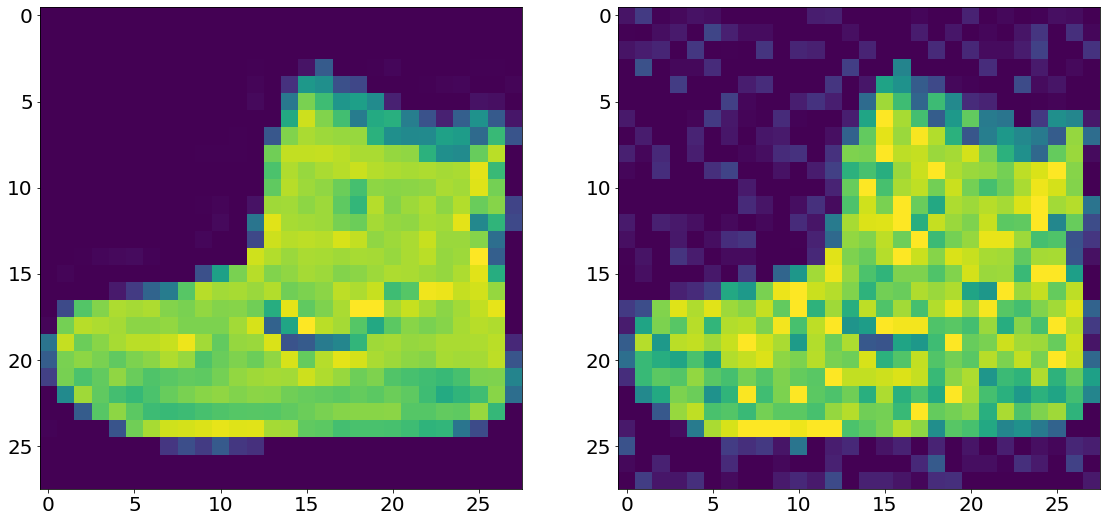

In [ ]:
image = FMNIST_train[0][0][0]
noise_image = add_noise(image)

fig, gs = plt.figure(figsize=(19,10)), gridspec.GridSpec(1, 2)

images = [image, noise_image]

ax = []

for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(images[i]))

plt.show()

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Teacher = TeacherModel().to(device)

_ = Teacher.train()
train_teacher(Teacher, fmnist_big, FMNIST_test, phi=lambda x: add_noise(x))

_ = Student.train()
list_of_test_acc_noise, list_of_test_losses_noise, _, _ =\
                        distillation_train(Student, fmnist_small, FMNIST_test, teacher=Teacher, phi=lambda x: add_noise(x))

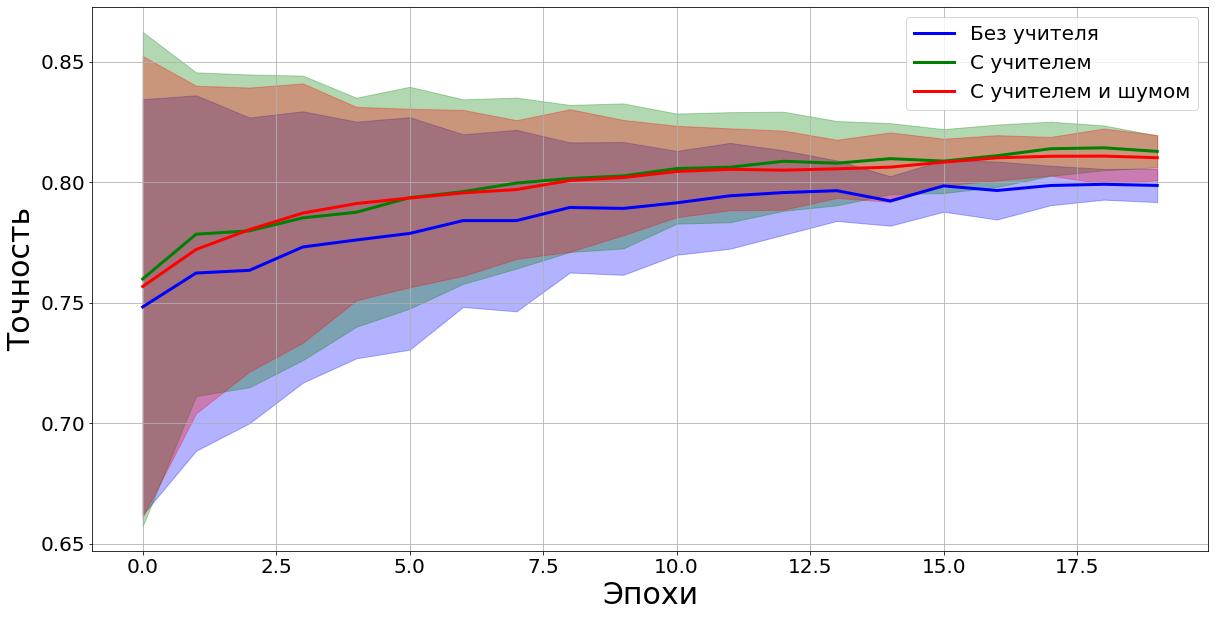

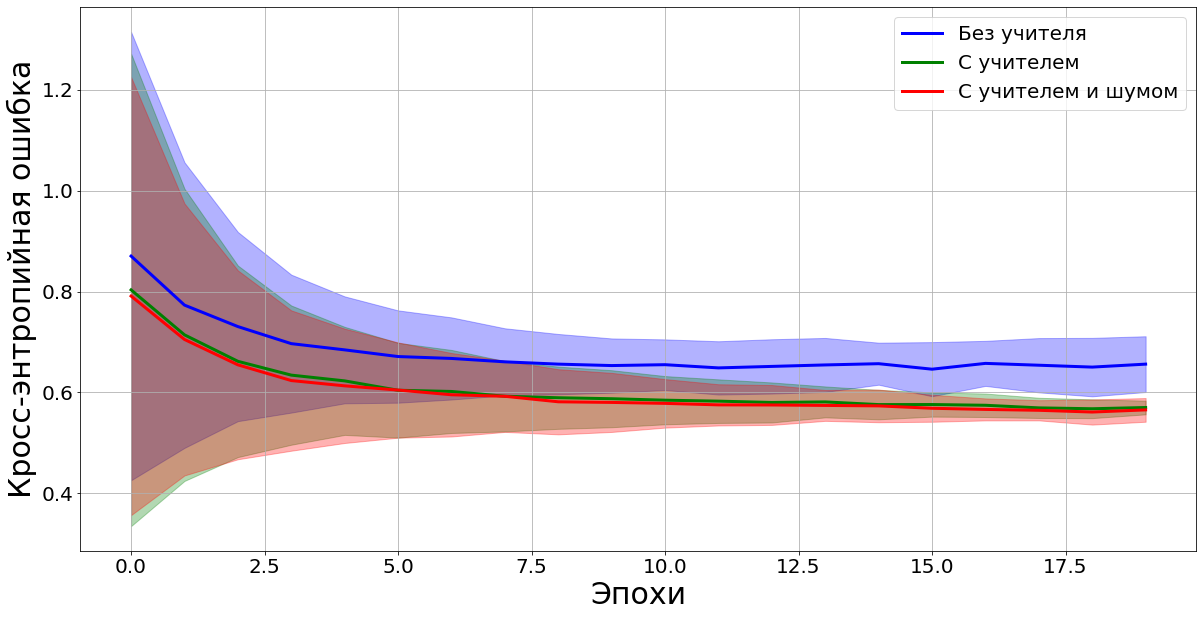

In [ ]:
labels = ['Без учителя', 'С учителем', 'С учителем и шумом']

makeplots(losses=[list_of_test_losses, list_of_test_losses_dist, list_of_test_losses_noise],
          labels=labels,
          accs=[list_of_test_acc, list_of_test_acc_dist, list_of_test_acc_noise])

In [ ]:
print('Accuracy of student with noise teacher={}+-{}'.format(round(np.array(list_of_test_acc_noise).mean(0)[-1],3),
                                                       round(np.array(list_of_test_acc_noise).std(0)[-1],3)))
print('Loss of student with noise teacher={}+-{}'.format(round(np.array(list_of_test_losses_noise).mean(0)[-1],3),
                                                   round(np.array(list_of_test_losses_noise).std(0)[-1],3)))
print('Integral criterion with noise teacher={}+-{}'.format(round(np.trapz(np.array(list_of_test_losses_noise).mean(0), np.arange(0,20)), 3),
                                                  round(np.trapz(np.array(list_of_test_losses_noise).std(0), np.arange(0,20)), 3)))

Accuracy of student with noise teacher=0.81+-0.009
Loss of student with noise teacher=0.565+-0.024
Integral criterion with noise teacher=11.362+-1.595


# Обучение на выборке с dilation

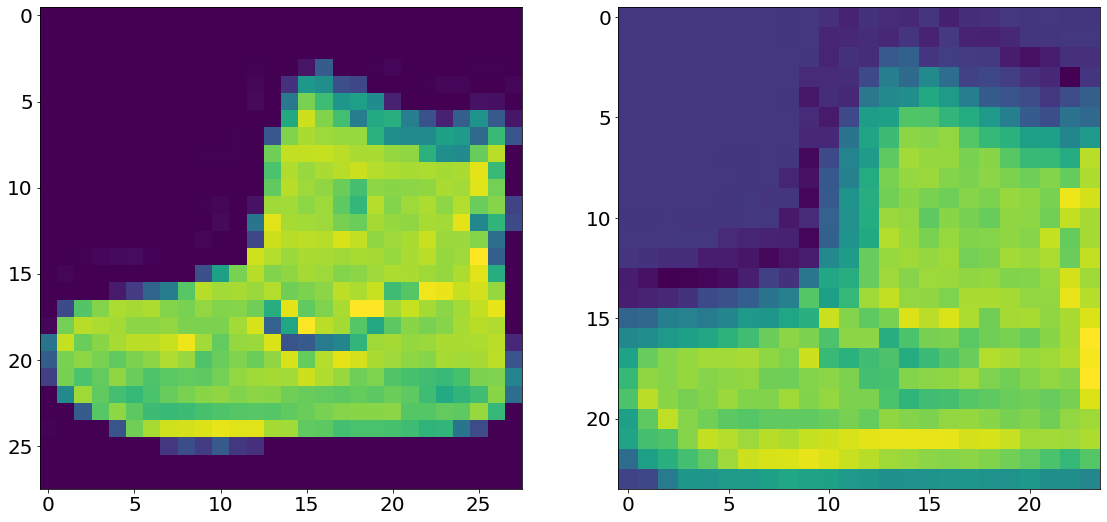

In [ ]:
image = FMNIST_train[0][0].to(device)
dilated_image = dilation(image).view([24,24])

fig, gs = plt.figure(figsize=(19,10)), gridspec.GridSpec(1, 2)

images = [image, dilated_image]

ax = []

for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(torch.squeeze(images[i]).cpu().detach().numpy()))

plt.show()

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Teacher = TeacherModel(input_dim=576).to(device)

_ = Teacher.train()
train_teacher(Teacher, fmnist_big, FMNIST_test, phi=lambda x: dilation(x))

_ = Student.train()
list_of_test_acc_dil, list_of_test_losses_dil, _, _ =\
                        distillation_train(Student, fmnist_small, FMNIST_test, teacher=Teacher, phi=lambda x: dilation(x))

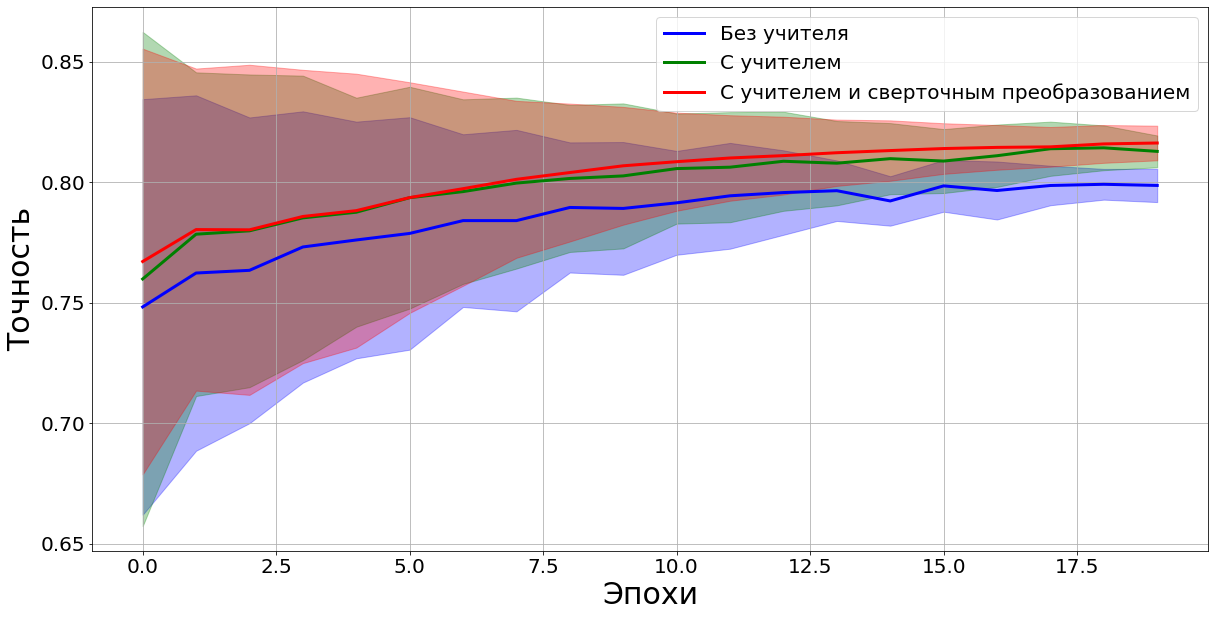

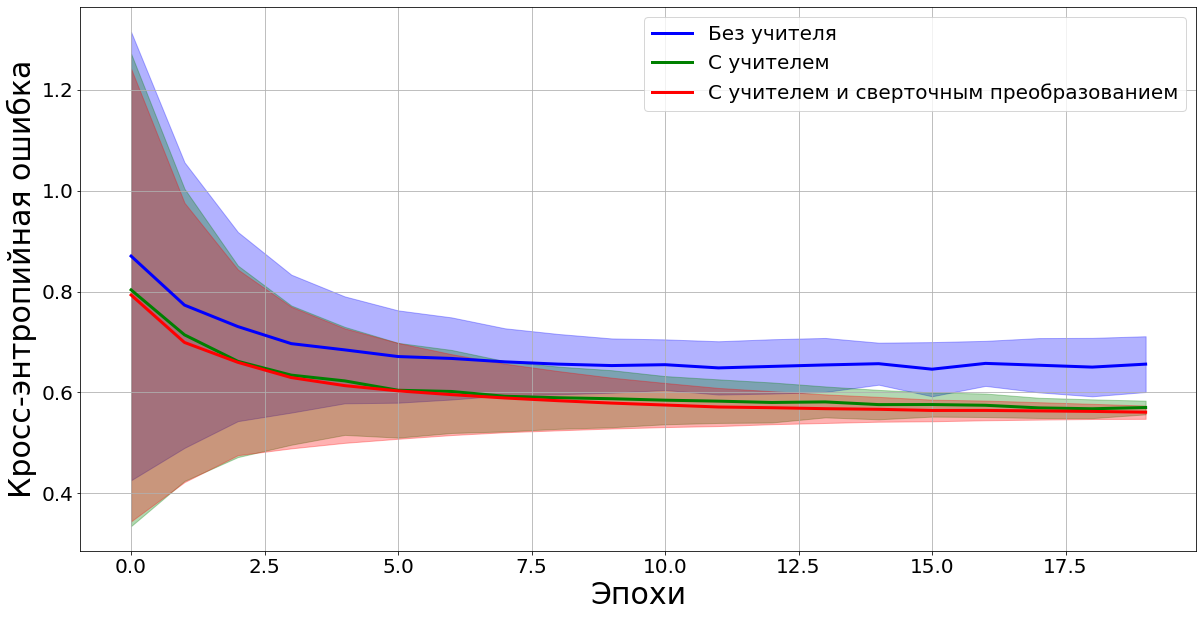

In [ ]:
labels = ['Без учителя', 'С учителем', 'С учителем и сверточным преобразованием']

makeplots(losses=[list_of_test_losses, list_of_test_losses_dist, list_of_test_losses_dil],
          labels=labels,
          accs=[list_of_test_acc, list_of_test_acc_dist, list_of_test_acc_dil])

In [ ]:
print('Accuracy of student with dilated teacher={}+-{}'.format(round(np.array(list_of_test_acc_dil).mean(0)[-1],3),
                                                       round(np.array(list_of_test_acc_dil).std(0)[-1],3)))
print('Loss of student with dilated teacher={}+-{}'.format(round(np.array(list_of_test_losses_dil).mean(0)[-1],3), 
                                                           round(np.array(list_of_test_losses_dil).std(0)[-1],3)))
print('Integral criterion with dilated teacher={}+-{}'.format(round(np.trapz(np.array(list_of_test_losses_dil).mean(0), np.arange(0,20)), 3),
                                                  round(np.trapz(np.array(list_of_test_losses_dil).std(0), np.arange(0,20)), 3)))

Accuracy of student with dilated teacher=0.816+-0.007
Loss of student with dilated teacher=0.561+-0.013
Integral criterion with dilated teacher=11.33+-1.54


# Отрисовка изменения 

In [ ]:
Autoencoder = VAE(2, 28*28)
Autoencoder.to(device)

optimizer = torch.optim.Adam

trainer(count_of_epoch=20, 
        batch_size=64, 
        dataset=FashionDigit,
        model=Autoencoder, 
        loss_function=None,
        optimizer = optimizer,
        lr = 0.001)

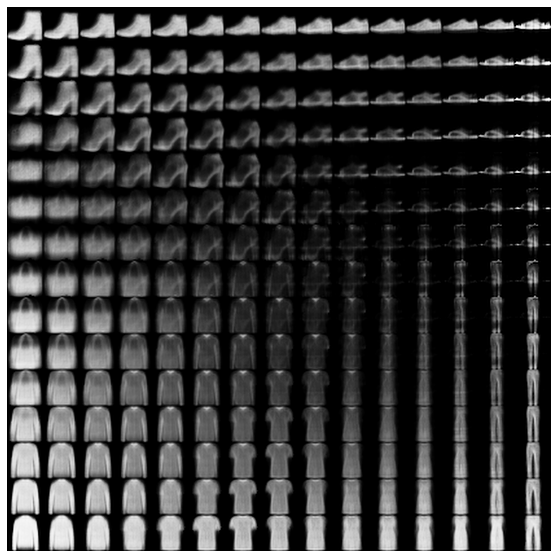

In [ ]:
figure = draw_samples_grid_vae(Autoencoder, dataset='fashion')

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r', interpolation='lanczos')
plt.axis('off')
plt.show()

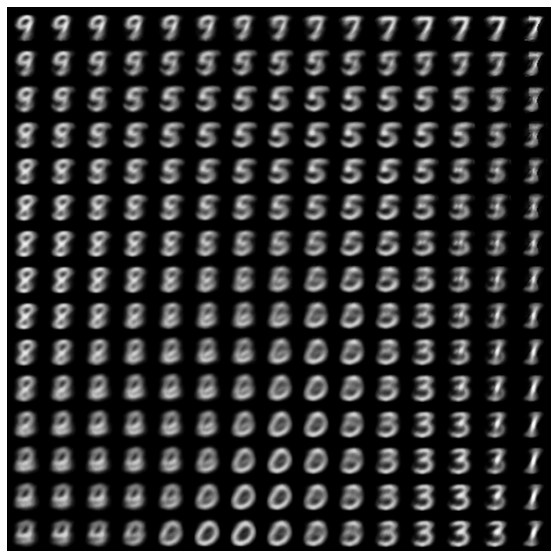

In [ ]:
figure = draw_samples_grid_vae(Autoencoder, dataset='digits')

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r', interpolation='lanczos')
plt.axis('off')
plt.show()

# $\varphi$=VAE

In [ ]:
Autoencoder = VAE(64, 28*28)
Autoencoder.to(device)

optimizer = torch.optim.Adam

trainer(count_of_epoch=50, 
        batch_size=64, 
        dataset=FashionDigit,
        model=Autoencoder, 
        loss_function=None,
        optimizer = optimizer,
        SEED=SEED,
        lr = 0.001)

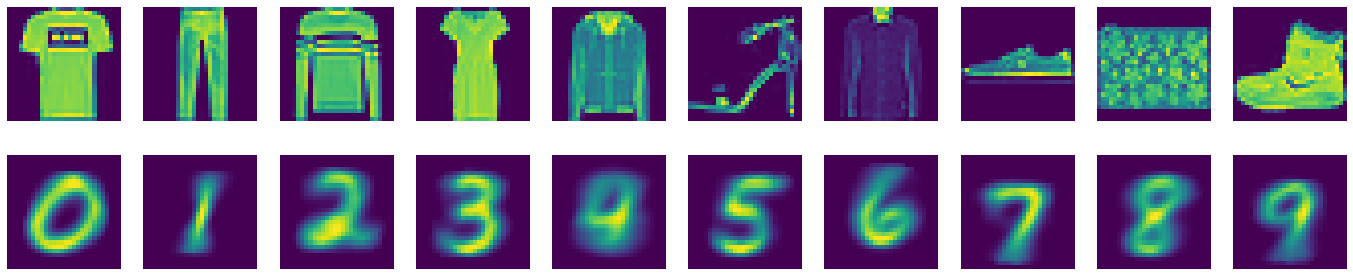

In [63]:
indices = [1,16,5,20,28,8,33,14,23,0]

fmnist_images = []
for i in indices:
    fmnist_images.append(FMNIST_train[i][0])

mnist_images = []
for im in fmnist_images:
    a = im.view([1,784])
    b = fmnist_to_mnist(Autoencoder, a).view([28,28])
    mnist_images.append(b.cpu().detach().numpy())    

fig, gs = plt.figure(figsize=(24,5)), gridspec.GridSpec(2, 10)

ax = []

for i in range(10):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(fmnist_images[i].view([28,28])))
    ax[i].axis('off')

for i in range(10):
    ax.append(fig.add_subplot(gs[i+10]))
    ax[i+10].imshow(np.array(mnist_images[i]))
    ax[i+10].axis('off')

plt.show()

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Teacher = TeacherModel().to(device)

_ = Teacher.train()
train_teacher(Teacher, mnist_big, MNIST_test)

_ = Student.train()
list_of_test_acc_mnist, list_of_test_losses_mnist, _, _ =\
                distillation_train(Student, fmnist_small, FMNIST_test, teacher=Teacher, phi=lambda x: fmnist_to_mnist(Autoencoder, x))

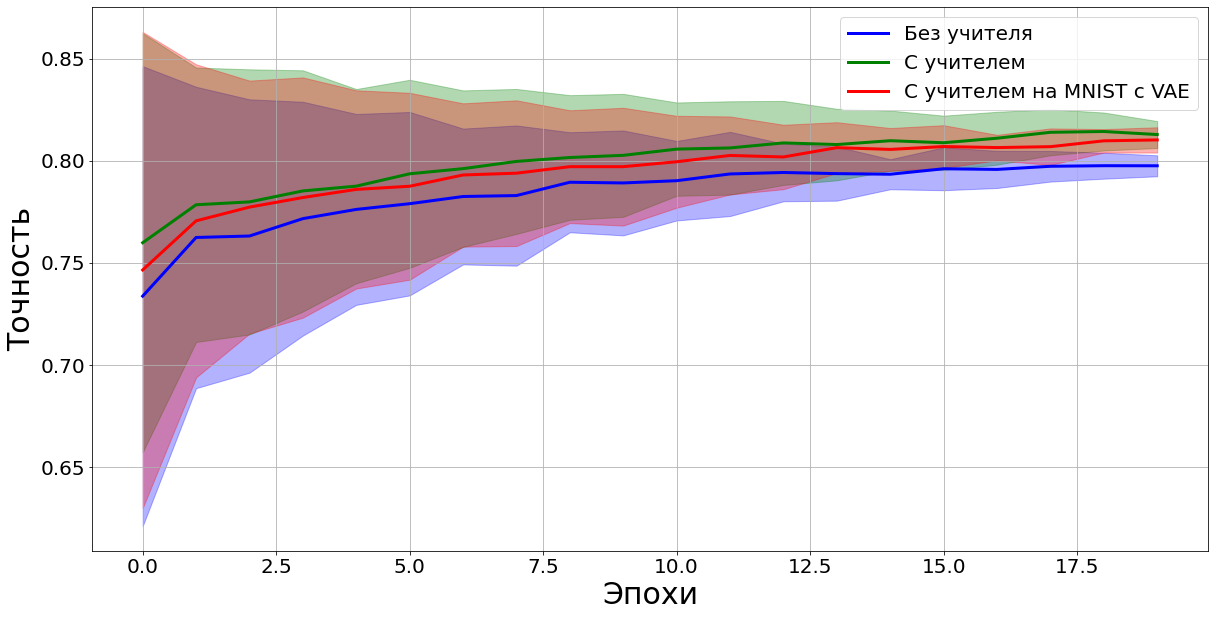

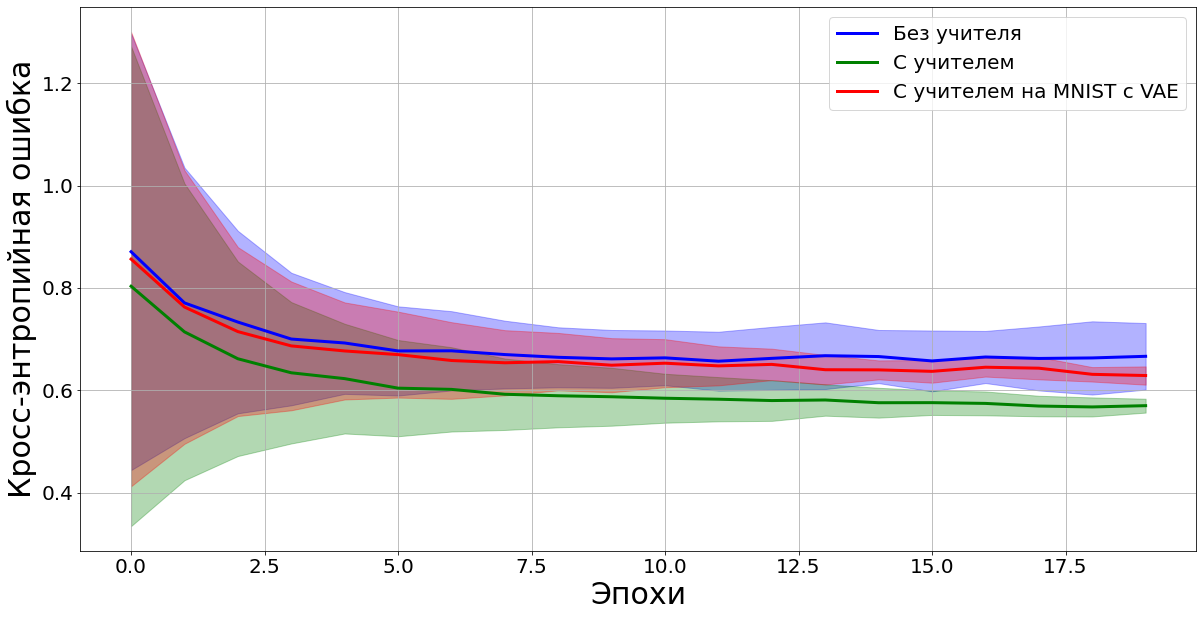

In [70]:
labels = ['Без учителя', 'С учителем', 'С учителем на MNIST с VAE']

makeplots(losses=[list_of_test_losses, list_of_test_losses_dist, list_of_test_losses_mnist],
          labels=labels,
          accs=[list_of_test_acc, list_of_test_acc_dist, list_of_test_acc_mnist])

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Teacher = TeacherModel().to(device)

_ = Teacher.train()
train_teacher(Teacher, mnist_big, MNIST_test)

_ = Student.train()
list_of_test_acc_mnist_no_vae, list_of_test_losses_mnist_no_vae, _, _ =\
                                distillation_train(Student, fmnist_small, FMNIST_test, teacher=Teacher)

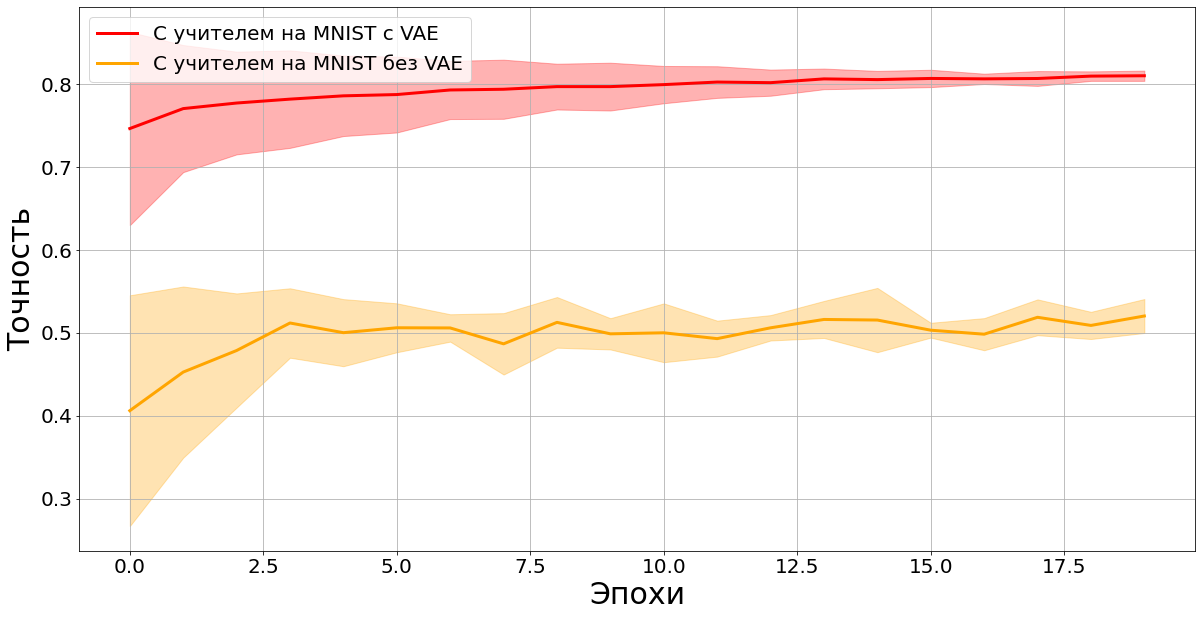

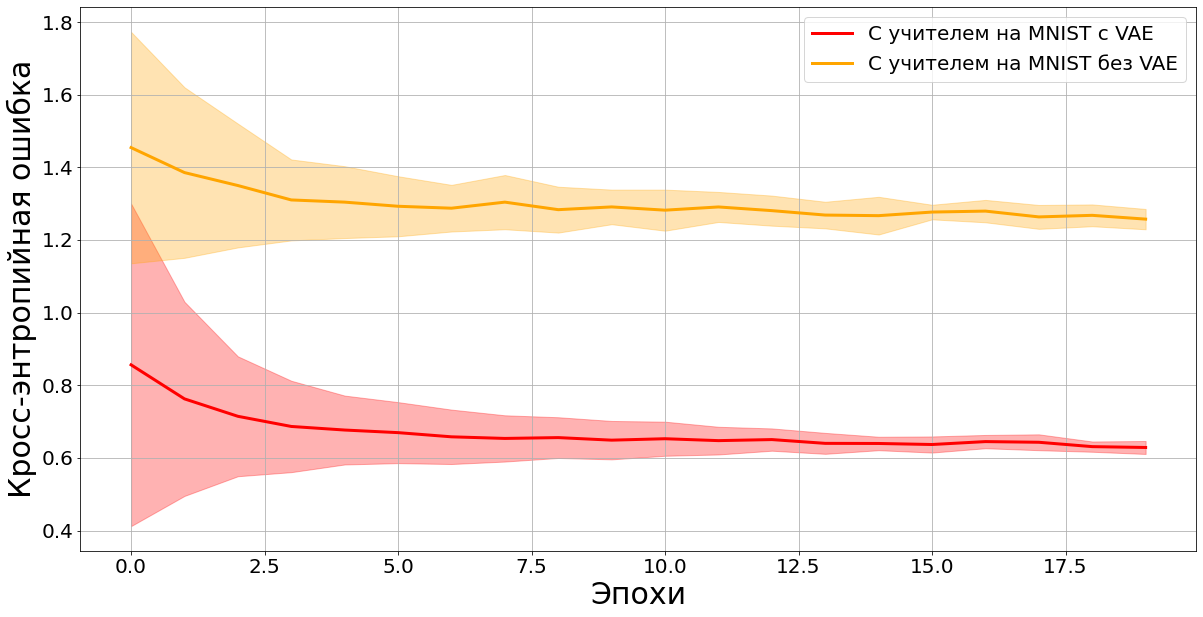

In [67]:
labels = ['С учителем на MNIST с VAE', 'С учителем на MNIST без VAE']

makeplots(losses=[list_of_test_losses_mnist, list_of_test_losses_mnist_no_vae],
          labels=labels,
          accs=[list_of_test_acc_mnist, list_of_test_acc_mnist_no_vae], colors=['red', 'orange'])

In [71]:
print('Accuracy of student with teacher on MNIST with VAE={}+-{}'.format(round(np.array(list_of_test_acc_mnist).mean(0)[-1],3),
                                                                         round(np.array(list_of_test_acc_mnist).std(0)[-1],3)))
print('Loss of student with teacher on MNIST with VAE={}+-{}'.format(round(np.array(list_of_test_losses_mnist).mean(0)[-1],3),
                                                                     round(np.array(list_of_test_losses_mnist).std(0)[-1],3)))
print('Accuracy of student with teacher on MNIST w/o VAE={}+-{}'.format(round(np.array(list_of_test_acc_mnist_no_vae).mean(0)[-1],3),
                                                                        round(np.array(list_of_test_acc_mnist_no_vae).std(0)[-1],3)))
print('Loss of student with teacher on MNIST w/o VAE={}+-{}'.format(round(np.array(list_of_test_losses_mnist_no_vae).mean(0)[-1],3),
                                                                round(np.array(list_of_test_losses_mnist_no_vae).std(0)[-1],3)))
print('Integral criterion with teacher on MNIST with VAE={}+-{}'.format(round(np.trapz(np.array(list_of_test_losses_mnist).mean(0),
                                                                                   np.arange(0,20)), 3),
                                                                        round(np.trapz(np.array(list_of_test_losses_mnist).std(0),
                                                                                       np.arange(0,20)), 3)))
print('Integral criterion with teacher on MNIST w/o VAE={}+-{}'.format(round(np.trapz(np.array(list_of_test_losses_mnist_no_vae).mean(0),
                                                                                  np.arange(0,20)), 3),
                                                                       round(np.trapz(np.array(list_of_test_losses_mnist_no_vae).std(0),
                                                                                      np.arange(0,20)), 3)))

Accuracy of student with teacher on MNIST with VAE=0.81+-0.006
Loss of student with teacher on MNIST with VAE=0.629+-0.018
Accuracy of student with teacher on MNIST w/o VAE=0.52+-0.02
Loss of student with teacher on MNIST w/o VAE=1.257+-0.028
Integral criterion with teacher on MNIST with VAE=12.657+-1.455
Integral criterion with teacher on MNIST w/o VAE=24.642+-1.462


# Синтетически расширенная сгенерированная выборка

In [ ]:
GMNIST_train, GMNIST_test = GeneratedMNIST(fmnist_small, Autoencoder)

In [ ]:
gmnist_big, gmnist_small = torch.utils.data.random_split(GMNIST_train, [59000, 1000], generator=torch.Generator().manual_seed(42))

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Teacher = TeacherModel().to(device)

_ = Teacher.train()
train_teacher(Teacher, gmnist_big, GMNIST_test)

_ = Student.train()
list_of_test_acc_ext_mnist, list_of_test_losses_ext_mnist, _, _ =\
                distillation_train(Student, fmnist_small, FMNIST_test, teacher=Teacher, phi=lambda x: fmnist_to_mnist(Autoencoder, x))

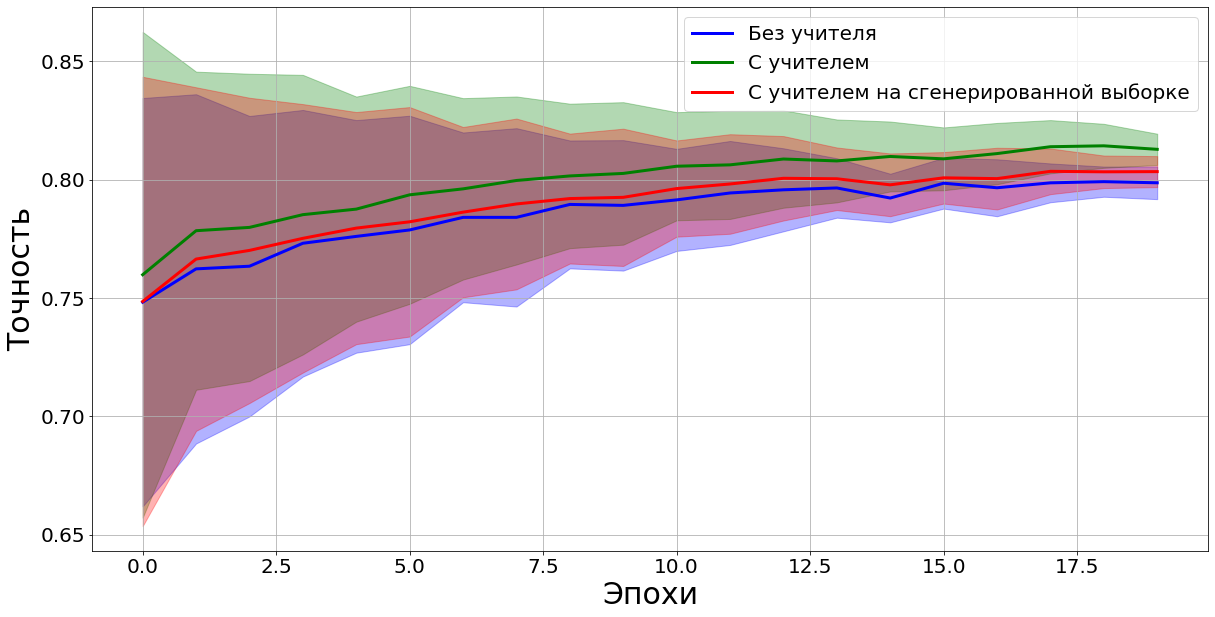

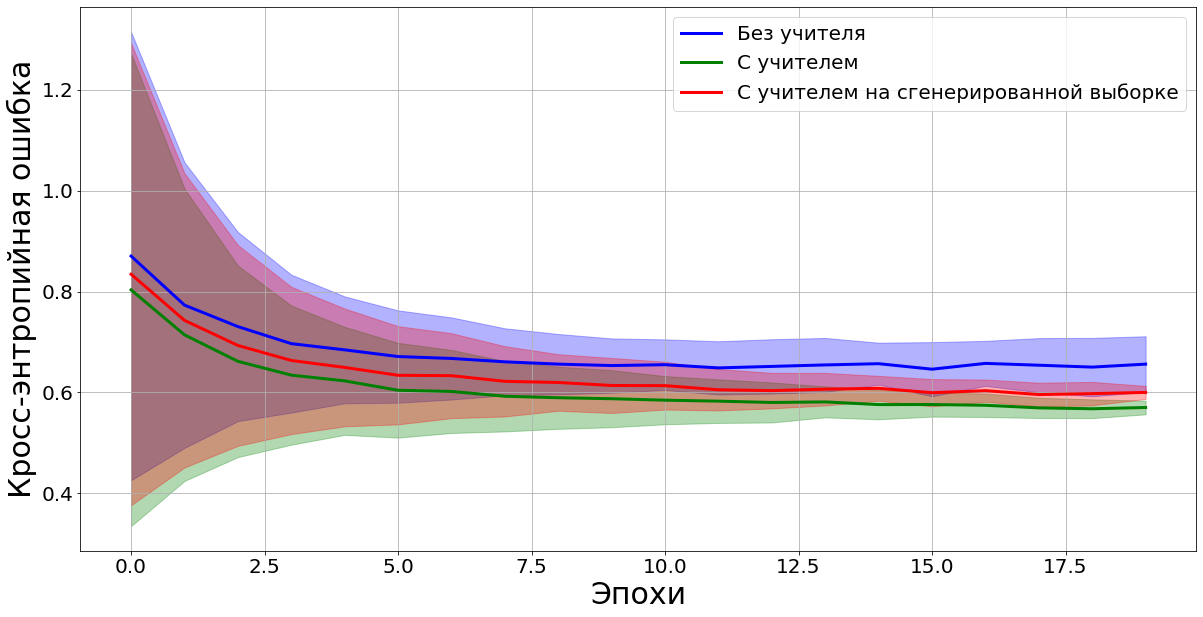

In [ ]:
labels = ['Без учителя', 'С учителем', 'С учителем на сгенерированной выборке']

makeplots(losses=[list_of_test_losses, list_of_test_losses_dist, list_of_test_losses_ext_mnist],
          labels=labels,
          accs=[list_of_test_acc, list_of_test_acc_dist, list_of_test_acc_ext_mnist])

In [ ]:
print('Accuracy of student with teacher on synthetic extended MNIST={}+-{}'.format(round(np.array(list_of_test_acc_ext_mnist).mean(0)[-1],3),
                                                                                   round(np.array(list_of_test_acc_ext_mnist).std(0)[-1],3)))
print('Loss of student with teacher on synthetic extended={}+-{}'.format(round(np.array(list_of_test_losses_ext_mnist).mean(0)[-1],3),
                                                                         round(np.array(list_of_test_losses_ext_mnist).std(0)[-1],3)))
print('Integral criterion with teacher on synthetic extended MNIST={}+-{}'.format(round(np.trapz(np.array(list_of_test_losses_ext_mnist).mean(0),
                                                                                             np.arange(0,20)), 3),
                                                                                  round(np.trapz(np.array(list_of_test_losses_ext_mnist).std(0),
                                                                                                 np.arange(0,20)), 3)))

Accuracy of student with teacher on synthetic extended MNIST=0.803+-0.007
Loss of student with teacher on synthetic extended=0.6+-0.013
Integral criterion with teacher on synthetic extended MNIST=12.019+-1.629
